In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import cross_val_score

from tradPointOut import rankToPoints2017
from tabulabuilder import School

sns.set_style("whitegrid")

In [2]:
rawDf = pd.read_csv("data/tier7QLonly.csv")
df = rawDf.copy()
df.isRelay = df.isRelay.astype(int)

df2019 = pd.read_csv("data/2019.csv")
df2019.isRelay = df2019.isRelay.astype(int)
df2019["school"] = df2019["school"].apply(lambda idx: School.get_by_id(idx).name)

In [3]:
# df2018 = df.loc[df["year"] == 2018]
# testSet = df2018.sample(frac = 0.7, random_state = 42)
# testY = testSet.pop("points")
# testX = testSet.copy()

trainSet = df#[~df.index.isin(testSet.index)]
trainY = trainSet.pop("points")
trainX = trainSet.copy()

xCols = ["divsSpeed", "isRelay", "divsTimePctOfMean",  "clipped_divsRank"]

x2019 = df2019[xCols]

trainX = trainX[xCols] 
# testX = testX[xCols] 

In [4]:
df2019["tradPred"] = df2019.apply(lambda row: rankToPoints2017(row["divsRank"]), axis=1)

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=2000, criterion="friedman_mse", min_samples_leaf=64, learning_rate=0.1)
gbr = gbr.fit(trainX, trainY)
scores = cross_val_score(gbr, trainX, trainY, cv=4)
print(f"R^2: {scores.mean()} (+/- {scores.std() * 2})")

gbrY = gbr.predict(x2019)
df2019["gbrPred"] = gbrY

pd.DataFrame([xCols, gbr.feature_importances_])

R^2: 0.7180200865280457 (+/- 0.19808569621143093)


,0,1,2,3
0,divsSpeed,isRelay,divsTimePctOfMean,clipped_divsRank
1,0.0346456,0.00121024,0.0456941,0.91845


In [6]:
df2019.to_csv("data/2019PredsWholeModel.csv")

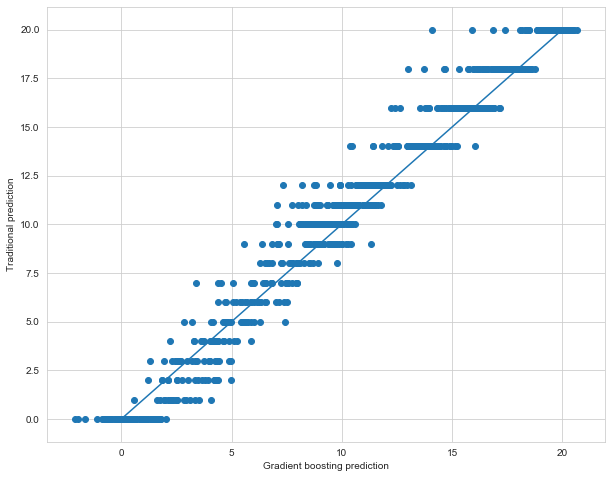

In [7]:
plt.figure(figsize = (10,8))
plt.xlabel("Gradient boosting prediction")
plt.ylabel("Traditional prediction")
lineX = np.linspace(0,20,20)
plt.plot(lineX, lineX)
plt.scatter(df2019["gbrPred"], df2019["tradPred"])